In [ ]:
from shapely.geometry import *
from shapely.affinity import *
from shapely.ops import *

import matplotlib.pyplot as plt
import numpy as np

# Install gdal according to python version: GDAL-3.4.2-cp39-cp39-win_amd64.whl
# Install fiona according to python version: https://www.lfd.uci.edu/~gohlke/pythonlibs/#fiona
import geopandas as gpd

In [ ]:
# Interseciont over Union (IOU)
# Define Each polygon 
pol1_xy = [[130, 27], [129.52, 27], [129.45, 27.1], [130.13, 26]]
pol2_xy = [[30, 27.200001], [129.52, 27.34], [129.45, 27.1], [130.13, 26.950001]]
polygon1_shape = Polygon(pol1_xy)
polygon2_shape = Polygon(pol2_xy)

# Calculate Intersection and union, and tne IOU
polygon_intersection = polygon1_shape.intersection(polygon2_shape).area
polygon_union = polygon1_shape.union(polygon2_shape).area
IOU = polygon_intersection / polygon_union 
print(IOU)

def IOU(polygon1_shape, polygon2_shape):
    # Union of quadrilaterals is costly operation!
    # Calculate intersection and union, and the IOU
    polygon_intersection = polygon1_shape.intersection(polygon2_shape).area
    polygon_union = polygon1_shape.area + polygon2_shape.area - polygon_intersection
    return polygon_intersection / polygon_union


In [ ]:
# import shapely.geometry as sg
# import shapely.affinity as sa

n = 3
k = 3
ori = Point([0, 0])
p = [Point([0, 1])]

for side in range(1, n):
    p.append(rotate(p[-1], 360/n, origin=ori))  # shaply.affinity.rotate
ngon = Polygon(p)

plt.figure()
plt.plot(*ngon.exterior.xy, "-k")

plt.scatter(*np.transpose([ngon.exterior.interpolate(t).xy for t in np.linspace(0, ngon.length, k, False)])[0])

plt.axis("equal")
plt.box("off")
plt.axis("off")
plt.show(block=0)


In [ ]:
npts = 3;int(ngon.length/0.25)
pts = [ngon.exterior.interpolate(t).xy for t in np.linspace(0, ngon.length, npts)]
# MultiPoint(np.transpose(pts)[0])
# np.transpose(pts)[0]
pts

In [ ]:
c1 = Point(0, 0).buffer(5)
c2 = Point(1, 0).buffer(5)
print(f"c1: {c1.area:0.2f} m2, c2: {c2.area:0.2f} m2, c1+c2: {c1.area+c2.area:0.2f}")

In [ ]:
print(f"intersection(c1, c2): {c1.intersection(c2).area:0.2f} m2")  # common area between two circles
print(f"union(c1, c2): {c1.union(c2).area:0.2f} m2")  # total area
print(f"symmetric_difference(c1, c2): {c1.symmetric_difference(c2).area:0.2f} m2")  # total area except the overlap
print(f"difference(c1, c2): {c1.difference(c2).area:0.2f} m2")  # Subtract the c2 from c1 and result the remaining shape.
c1.symmetric_difference(c2)
# c1.difference(c2)  

In [ ]:
# Multipile polygon
lst = []
for x in range(0, 3):
    for y in range(0, 3):
        lst.append(Point(x, y).buffer(1))
        
mpg = MultiPolygon(lst)
# unary_union(mpg)  # Total scan area
mpg

In [ ]:
prev = None
ist = []
for pg in mpg:
    if prev is None:
        prev = pg
    else:
        # ist = pg.symmetric_difference(ist)
        ist.append(prev.intersection(pg))
        prev = pg

ist = MultiPolygon(ist)
# unary_union(ist)
ist

In [ ]:
temp = unary_union(mpg)
temp1 = temp.difference(Point(0,0).buffer(1))
temp1

In [ ]:
lst = []
for x in range(0, 4):
    for y in range(0, 4):
        lst.append(Point(x, y).buffer(0.707))     
gdf = gpd.GeoDataFrame({'geometry': gpd.GeoSeries(lst)})
gdf.plot(alpha=0.1, figsize=(16, 8))

In [ ]:
from rtree import index
idx = index.Index()

# Populate R-tree index with bounds of grid cells
for pos, cell in enumerate(mpg.geoms):
    # assuming cell is a shapely object
    idx.insert(pos, cell.bounds)
    
# Loop through each Shapely polygon
lst = []
for poly in mpg.geoms:
    # Merge cells that have overlapping bounding boxes
    merged_cells = unary_union([mpg[pos] for pos in idx.intersection(poly.bounds)])
    # Now do actual intersection
    lst.append(poly.intersection(merged_cells))
    
MultiPolygon(lst)

In [ ]:
c00 = Point(0, 0).buffer(1)
c01 = Point(0, 1).buffer(1)
c02 = Point(0, 2).buffer(1)
c0 = c01.intersection(c00.union(c02)) 

c10 = Point(1, 0).buffer(1)
c11 = Point(1, 1).buffer(1)
c12 = Point(1, 2).buffer(1)
c1 = c11.intersection(c10.union(c12)) 

c20 = Point(2, 0).buffer(1)
c21 = Point(2, 1).buffer(1)
c22 = Point(2, 2).buffer(1)
c2 = c21.intersection(c20.union(c22)) 

c1.intersection(c0.union(c2))  # Region with 4 overlapping circles


In [ ]:
from sklearn.neighbors import KDTree
import numpy as np
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
kdt = KDTree(X, leaf_size=30, metric='euclidean')
# dist, idx = kdt.query(X[:1], k=3, return_distance=True) # Return distance and index of the three neighbours
idx, dist = kdt.query_radius(X[:1], r=5, return_distance=True, count_only=False) # Return distance and index within radius
print(dist)
print(idx)
# kdt.query_radius(X[:1], r=1, count_only=True, sort_results=True) # Return distance and index within radius


In [ ]:
radius = 1
centers = [[x,y] for x in range(0, 3, radius) for y in range(0, 3, radius)]
kdt = KDTree(centers, leaf_size=30, metric='euclidean')
idx, dist = kdt.query_radius([centers[0]], r=2*radius, count_only=False, return_distance=True, sort_results=True)
print(idx.tolist())
print(dist)

In [ ]:
import open_street_map as osm

In [ ]:
# gdf, bbox, pgx = osm.get_holes_and_bbox((51.89030, 10.41933), 100, 10)
gdf, bbox, pgx = osm.get_holes_and_bbox((49.81051384510241, 9.988340883784735), 100, 10)


In [ ]:
pgx1 = osm.inflate_holes(pgx, 15, False)

In [ ]:
from matplotlib import pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union

poly1 = Polygon([(0,0), (2,0), (2,2), (0,2)])
poly2 = Polygon([(2,2), (4,2), (4,4), (2,4)])
poly3 = Polygon([(1,1), (3,1), (3,3), (1,3)])
poly4 = Polygon([(3,3), (5,3), (5,5), (3,5)])
polys = MultiPolygon([poly1, poly2, poly3, poly4])     
mergedPolys = unary_union(polys)
# type(mergedPolys)

for p in polys:
    print(p)

# gpd.GeoSeries(polys).boundary.plot()
# plt.show()


In [ ]:
import open_street_map as osm
import numpy as np
# gdf, bbox, pgx = osm.get_holes_and_bbox((51.89030, 10.41933), 100, 10)
gdf, bbox, pgx = osm.get_holes_and_bbox((49.81051384510241, 9.988340883784735), 100, 10)
pgx1 = osm.inflate_holes(pgx, 15, False)


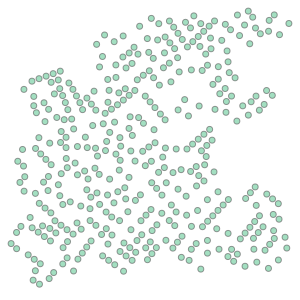

In [73]:
mpg = unary_union(gdf.geometry).buffer(1)

pts = []
max_inflation_distance = 10
simplify = True

from shapely.geometry import MultiPoint

if isinstance(mpg, Polygon):
    for d in np.arange(0, mpg.boundary.length, max_inflation_distance):
        pt = mpg.boundary.interpolate(d)
        # pts.append(pt)
        pts.append([pt.x, pt.y])
        
elif isinstance(mpg, MultiPolygon):
    for g in mpg.boundary.geoms:
        for d in np.arange(0, g.length, max_inflation_distance):
            pt = g.interpolate(d)
            if simplify:
                if not pt.buffer(max_inflation_distance, join_style=JOIN_STYLE.bevel).intersection(MultiPoint(pts)):
                    # pts.append(pt)
                    pts.append([pt.x, pt.y])
            else:
                # pts.append(pt)
                pts.append([pt.x, pt.y])

MultiPoint(pts)

In [84]:
from shapely.geometry import MultiPolygon

# Create the first Polygon
polygon1 = Polygon([(0,0), (0,1), (1,1), (1,0)])

# Create the second Polygon
polygon2 = Polygon([(2,2), (2,3), (3,3), (3,2)])

# Create the MultiPolygon object
multipolygon = MultiPolygon([polygon1, polygon2])

# Iterate through the polyggon components
for polygon in multipolygon:
    # Get the exterior ring of the polygon
    exterior = polygon.exterior
    # Get the coordinates of the vertices
    vertices = list(exterior.coords)
    # Print the vertices
    print(exterior.coords)


/tmp/ipykernel_31174/1968784657.py:13: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in multipolygon:


In [ ]:
from shapely.geometry import LineString

# Create a polyline
line = [(0, 0), (0, 1), (1, 1), (1, 0)]
polyline = LineString(line)

# Sampling distance
distance = 0.13

# Calculate the number of samples needed
num_samples = int(polyline.length / distance)

# Create a list of equal distance points on the polyline
# points = [polyline.interpolate(d * (polyline.length / num_samples)) for d in range(num_samples + 1)]
# for pt in points:
#     print(f"{pt.x:0.2f}, {pt.y:0.2f}")
    
polygon = Polygon([(0,0), (0,1), (1,1), (1,0), (0,0)])
# Get the exterior boundary
exterior = polygon.exterior
# Iterate over the points in the exterior boundary
edges = []
for i in range(len(exterior.coords) - 1):
    start = exterior.coords[i]
    end = exterior.coords[i+1]
    edges.append([start, end])

# Print the edges
print(edges)

In [ ]:
from shapely.geometry import Polygon
from shapely.geometry import JOIN_STYLE
# create a rectangle polygon
rectangle = Polygon([(10, 10), (10, 20), (20, 20), (20, 10)])

# round the corners
rounded_corners = rectangle.buffer(10, join_style=JOIN_STYLE.bevel)
rounded_corners
exterior = rounded_corners.exterior
# Iterate over the points in the exterior boundary
edges = []
for i in range(len(exterior.coords) - 1):
    start = exterior.coords[i]
    end = exterior.coords[i+1]
    edges.append([start, end])
edges

In [ ]:
from shapely.geometry import LinearRing, LineString, Point, Polygon
from shapely.geometry.polygon import orient
from shapely.geometry import CAP_STYLE, JOIN_STYLE

# create a linear ring
linear_ring = LinearRing([(0, 0), (0, 1), (1, 1), (1, 0)])

# buffer the linear ring with a positive distance
buffer_polygon_round_corners = linear_ring.buffer(0.1, cap_style=CAP_STYLE.round, join_style=JOIN_STYLE.round)

# buffer the linear ring with a negative distance
buffer_polygon_pointed_corners = linear_ring.buffer(0.1, cap_style=CAP_STYLE.round, join_style=JOIN_STYLE.mitre)

# buffer the linear ring with a negative distance
buffer_polygon_flat_corners = linear_ring.buffer(0.1, cap_style=CAP_STYLE.round, join_style=JOIN_STYLE.bevel)

linear_ring
buffer_polygon_round_corners
# buffer_polygon_pointed_corners
# buffer_polygon_flat_corners

In [ ]:
from shapely.geometry import LineString, Point
import matplotlib.pyplot as plt

# Sampling distance
distance = 2.0

# Define a LineString
line = LineString([(0, 0), (10, 0), (10, 10)])

# Define a buffer with a distance of 1 unit and round cap style
buffered_line_round = line.buffer(1, cap_style=CAP_STYLE.round, join_style=JOIN_STYLE.bevel)

# Define a buffer with a distance of 1 unit and flat cap style
buffered_line_flat = line.buffer(1, cap_style=CAP_STYLE.flat, join_style=JOIN_STYLE.bevel)

# Define a buffer with a distance of 1 unit and square cap style
buffered_line_square = line.buffer(1, cap_style=CAP_STYLE.square, join_style=JOIN_STYLE.bevel)

# Plot the results
fig, ax = plt.subplots()

# Plot the original LineString
x, y = line.xy
ax.plot(x, y, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

# Plot the buffered LineString with round cap style
x, y = buffered_line_round.boundary.xy
ax.plot(x, y, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

# Plot the buffered LineString with flat cap style
x, y = buffered_line_flat.boundary.xy
ax.plot(x, y, color='green', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

# Plot the buffered LineString with square cap style
x, y = buffered_line_square.boundary.xy
ax.plot(x, y, color='yellow', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

# Calculate the number of samples needed
num_samples = int(line.length / distance)
# Create a list of equal distance points on the polyline
points = [line.interpolate(d * (line.length / num_samples)) for d in range(num_samples + 1)]
x, y = LineString(points).xy
ax.scatter(x, y, color='magenta', alpha=0.7, linewidth=3, zorder=2)

# Show the plot
plt.axis('equal')
plt.show()

In [ ]:
# line.buffer(2, cap_style=JOIN_STYLE.bevel).buffer(-2, cap_style=JOIN_STYLE.bevel)
line = LineString([(0, 0), (1, 1), (2, 0)])
line.buffer(0.25, cap_style=CAP_STYLE.flat,join_style=JOIN_STYLE.bevel).buffer(-0.125,cap_style=CAP_STYLE.flat,join_style=JOIN_STYLE.bevel)

In [ ]:
from shapely.geometry import LineString, Point

# Line segment defined as a shapely LineString
line = LineString([(0, 0), (1, 0)])

# Specified point
point = Point(0.5, 0.5)

# Euclidean distance
distance = 0.1

# Find the nearest point on the line
nearest_point = line.interpolate(line.project(point))
print(nearest_point)

# Calculate the vector from the specified point to the nearest point on the line
vector = nearest_point - point
print(vector, vector.length)
# Find the two points at the specified euclidean distance from the specified point
# point1 = point + vector * distance / vector.length
# point2 = point - vector * distance / vector.length

# Verify that the points are at the specified distance from the specified point
# assert point1.distance(point) == distance
# assert point2.distance(point) == distance

In [ ]:
from shapely.geometry import Point, LineString

point = Point(0, 0)
point1 = Point(10, 10)
distance = 5

line = LineString([point, point1])
vector = line.parallel_offset(distance, 'left', join_style=2)

new_point = Point(vector.coords[1])


In [ ]:
from shapely.geometry import Point, LineString
import numpy as np

def get_point_on_line_segment_at_distance(point, line_segment, distance):
    start, end = line_segment.xy
    start, end = np.array(start), np.array(end)
    line_vector = end - start
    line_length = np.linalg.norm(line_vector)
    unit_vector = line_vector / line_length

    distance_from_start = np.dot(unit_vector, point.coords[0] - start)
    if distance_from_start <= 0:
        return Point(*start)
    if distance_from_start >= line_length:
        return Point(*end)
    
    interpolated_point = start + unit_vector * distance_from_start + unit_vector * distance
    return Point(*interpolated_point)

point = Point(0.5, 0.5)
line_segment = LineString([(0, 0), (1, 1)])
distance = 0.2
result = get_point_on_line_segment_at_distance(point, line_segment, distance)
print(result)

In [ ]:
from shapely.geometry import LineString, Point
import numpy as np

def find_points(p1, p2, p3, distance):
    # Define two lines
    line1 = LineString([p1, p2])
    line2 = LineString([p2, p3])

    # Calculate unit vector of each line
    unit_vector1 = np.array(p2) - np.array(p1)
    unit_vector1 = unit_vector1 / np.linalg.norm(unit_vector1)
    unit_vector2 = np.array(p3) - np.array(p2)
    unit_vector2 = unit_vector2 / np.linalg.norm(unit_vector2)

    # Calculate perpendicular vector to each line's unit vector
    perpendicular_vector1 = np.array([-unit_vector1[1], unit_vector1[0]])
    perpendicular_vector2 = np.array([-unit_vector2[1], unit_vector2[0]])

    # Find two points on each line
    point1 = np.array(p2) + perpendicular_vector1 * distance
    point2 = np.array(p2) + perpendicular_vector2 * distance

    return Point(point1), Point(point2)

# Define the three points (0,0), (1,0), and (1,1)
p1 = (0, 0)
p2 = (1, 0)
p3 = (1, 1)

# Define the euclidean distance desired
distance = 1

point1, point2 = find_points(p1, p2, p3, distance)

print("Point 1:", point1)
print("Point 2:", point2)
point1.distance(point2)

In [ ]:
import math

def find_points_on_lines(x1, y1, x2, y2, x3, y3, d):
    x_diff1 = x2 - x1
    y_diff1 = y2 - y1
    x_diff2 = x3 - x2
    y_diff2 = y3 - y2

    line1_length = math.sqrt(x_diff1**2 + y_diff1**2)
    line2_length = math.sqrt(x_diff2**2 + y_diff2**2)

    unit_vector1_x = x_diff1 / line1_length
    unit_vector1_y = y_diff1 / line1_length
    unit_vector2_x = x_diff2 / line2_length
    unit_vector2_y = y_diff2 / line2_length

    point1_x = x2 + unit_vector1_x * d / 2
    point1_y = y2 + unit_vector1_y * d / 2
    point2_x = x2 + unit_vector2_x * d / 2
    point2_y = y2 + unit_vector2_y * d / 2

    return (point1_x, point1_y), (point2_x, point2_y)

point1, point2 = find_points_on_lines(0, 0, 1, 0, 1, 1, 1)
print(point1)
print(point2)
np.sqrt(np.power(point1[0]-point2[0], 2) + np.power(point1[1]-point2[1], 2))

In [ ]:
import shapely.geometry as geometry
import numpy as np

# Define the lines
line1 = geometry.LineString([(0, 0), (1, 0)])
line2 = geometry.LineString([(1, 0), (1, 1)])

# Define the common endpoint
common_endpoint = line1.intersection(line2)

# Define the desired distance `d`
d = 1

# Create a unit vector pointing from the common endpoint in the direction of line1
unit_vector = np.array(line1.coords[-1]) - np.array(common_endpoint.coords[0])
unit_vector = unit_vector / np.linalg.norm(unit_vector)

# Create a unit vector perpendicular to the first unit vector
perpendicular_unit_vector = np.array([-unit_vector[1], unit_vector[0]])

# Create the two points
point1 = common_endpoint.coords[0] + unit_vector * d / 2
point2 = common_endpoint.coords[0] + perpendicular_unit_vector * d / 2

# Convert the points to Shapely Points
point1 = geometry.Point(point1)
point2 = geometry.Point(point2)
print("Point 1:", point1)
print("Point 2:", point2)
point1.distance(point2)

In [ ]:
from shapely.geometry import LineString, Point
from math import cos, sin, pi

def get_points_on_lines(p1, p2, p3, d):
    line1 = LineString([p1, p2])
    line2 = LineString([p2, p3])
    common_endpoint = p2
    angle = line1.project(common_endpoint)
    point1 = line1.interpolate(angle-(d/2)/line1.length)
    point2 = line2.interpolate(angle+(d/2)/line2.length)
    return point1, point2

d = 1
p1 = Point(0,0)
p2 = Point(1,0)
p3 = Point(2,1)
point1, point2 = get_points_on_lines(p1, p2, p3, d)
print("Point 1:", point1)
print("Point 2:", point2)
point1.distance(point2)

In [ ]:
from shapely.geometry import LineString, Point
from shapely.ops import split

# Define the common endpoint and the two line segments
common_endpoint = Point(1, 0)
line1 = LineString([(0, 0), (1, 0)])
line2 = LineString([(1, 0), (1, 1)])

# Split the lines at the common endpoint
_, l1, l2 = split(line1, common_endpoint)

# Get the direction vectors of the lines at the common endpoint
dir1 = l1.coords[1] - l1.coords[0]
dir2 = l2.coords[1] - l2.coords[0]

# Normalize the direction vectors to unit length
dir1 = dir1 / dir1.length
dir2 = dir2 / dir2.length

# Calculate the distance between the points
d = 1

# Calculate the points
point1 = common_endpoint + (dir1 + dir2) * (d / 2)
point2 = common_endpoint - (dir1 + dir2) * (d / 2)

# Check the euclidean distance between the points
print(point1.distance(point2))
from shapely.geometry import LineString, Point
from math import cos, sin, pi

def get_points_on_lines(p1, p2, p3, d):
    line1 = LineString([p1, p2])
    line2 = LineString([p2, p3])
    common_endpoint = p2
    angle = line1.project(common_endpoint)
    point1 = line1.interpolate(angle-(d/2)/line1.length)
    point2 = line2.interpolate(angle+(d/2)/line2.length)
    return point1, point2

d = 1
p1 = Point(0,0)
p2 = Point(1,0)
p3 = Point(2,1)
point1, point2 = get_points_on_lines(p1, p2, p3, d)
print("Point 1:", point1)
print("Point 2:", point2)
point1.distance(point2)

In [ ]:
from shapely.geometry import LineString, Point
import numpy as np

def get_points_on_lines(common_endpoint, line1, line2, d):
    # Calculate the direction vectors for each line
    dir1 = np.array(list(line1.coords))[1] - np.array(list(line1.coords))[0]
    dir2 = np.array(list(line2.coords))[1] - np.array(list(line2.coords))[0]
    # Scale the direction vectors to distance d
    dir1 = dir1 / np.linalg.norm(dir1) * d
    dir2 = dir2 / np.linalg.norm(dir2) * d
    # Add the direction vectors to the common endpoint
    point1 = common_endpoint + Point(dir1)
    point2 = common_endpoint + Point(dir2)
    return point1, point2

# Example usage
common_endpoint = Point(1, 0)
line1 = LineString([(0, 0), (1, 0)])
line2 = LineString([(1, 0), (1, 1)])
d = 1
point1, point2 = get_points_on_lines(common_endpoint, line1, line2, d)
print("Point 1:", point1)
print("Point 2:", point2)


In [ ]:
from shapely.geometry import LineString, Point
import numpy as np

# Define the line segments
line1 = LineString([(0,0), (1,0), (1,1)])
line2 = LineString([(0,0), (1,0), (2,0)])

# Find the common endpoint
common_endpoint = line1.intersection(line2)

# Choose a direction vector along one of the LineStrings
dir_vector = np.array([line1.coords[1][0] - line1.coords[0][0], line1.coords[1][1] - line1.coords[0][1]])

# Generate a point on the LineString that is a distance "d" away from the common endpoint
point1 = Point(common_endpoint.x + dir_vector[0] * d, common_endpoint.y + dir_vector[1] * d)

# Repeat for the other LineString
dir_vector = np.array([line2.coords[2][0] - line2.coords[1][0], line2.coords[2][1] - line2.coords[1][1]])
point2 = Point(common_endpoint.x + dir_vector[0] * d, common_endpoint.y + dir_vector[1] * d)
print("Point 1:", point1)
print("Point 2:", point2)
point1.distance(point2)

In [ ]:
from shapely.geometry import LineString, Point
import numpy as np

def line_circle_intersection(line, circle_center, circle_radius):
    x1, y1 = line.coords[0]
    x2, y2 = line.coords[1]
    cx, cy = circle_center
    r = circle_radius

    # Calculate the distance between the line and the center of the circle
    dx = x2 - x1
    dy = y2 - y1
    dr = np.sqrt(dx**2 + dy**2)
    D = x1*y2 - x2*y1

    # Calculate the intersection points
    delta = r**2 * dr**2 - D**2
    if delta < 0:
        # No intersection
        return []
    elif delta == 0:
        # One intersection
        x = (D*dy + np.sign(dy) * dx * np.sqrt(r**2 * dr**2 - D**2)) / dr**2
        y = (-D*dx + np.abs(dy) * np.sqrt(r**2 * dr**2 - D**2)) / dr**2
        return [Point(x, y)]
    else:
        # Two intersections
        x1 = (D*dy + np.sign(dy) * dx * np.sqrt(r**2 * dr**2 - D**2)) / dr**2
        y1 = (-D*dx + np.abs(dy) * np.sqrt(r**2 * dr**2 - D**2)) / dr**2
        x2 = (D*dy - np.sign(dy) * dx * np.sqrt(r**2 * dr**2 - D**2)) / dr**2
        y2 = (-D*dx - np.abs(dy) * np.sqrt(r**2 * dr**2 - D**2)) / dr**2
        return [Point(x1, y1), Point(x2, y2)]

# Example usage
line = LineString([(0, 0), (1, 1)])
circle_center = (0, 0)
circle_radius = 1
intersection_points = line_circle_intersection(line, circle_center, circle_radius)
for point in intersection_points:
    print(point)


In [ ]:
from shapely.geometry import LineString, Point, Polygon
import numpy as np

def line_circle_intersection(line, circle):
    x1, y1 = line.coords[0]
    x2, y2 = line.coords[1]
    r = circle.length / (2*np.pi)
    center = circle.centroid.coords[0]
    a = np.array(line.coords[1]) - np.array(line.coords[0])
    b = np.array(line.coords[0]) - np.array(center)
    delta = np.dot(a, b) ** 2 - np.dot(a, a) * (np.dot(b, b) - r ** 2)
    result = []
    if delta >= 0:
        t1 = (-np.dot(a, b) + np.sqrt(delta)) / np.dot(a, a)
        t2 = (-np.dot(a, b) - np.sqrt(delta)) / np.dot(a, a)
        # print(delta, t1, t2, r)
        if 0 <= t1 <= 1:
            x = x1 + t1 * (x2 - x1)
            y = y1 + t1 * (y2 - y1)
            result.append(Point(x, y))
        if 0 <= t2 <= 1:
            x = x1 + t2 * (x2 - x1)
            y = y1 + t2 * (y2 - y1)
            result.append(Point(x, y))
            
    return result

line = LineString([(0, 0), (2, 2)])
circle = Point(0.1, 0.1).buffer(1)
for p in line_circle_intersection(line, circle):
    print(p)


In [ ]:
from shapely.geometry import LineString, Point
import numpy as np

def line_segment_circle_intersection(line, center, radius):
    x1, y1 = line.coords[0]
    x2, y2 = line.coords[1]
    cx, cy = center.coords[0]

    # calculate the coefficients of the quadratic equation
    a = (x2 - x1) ** 2 + (y2 - y1) ** 2
    b = 2 * ((x2 - x1) * (x1 - cx) + (y2 - y1) * (y1 - cy))
    c = cx ** 2 + cy ** 2 + x1 ** 2 + y1 ** 2 - 2 * (cx * x1 + cy * y1) - radius ** 2

    # calculate the discriminant
    disc = b ** 2 - 4 * a * c

    if disc < 0:
        return []
    elif disc == 0:
        t = -b / (2 * a)
        if 0 < t < 1:
            x = x1 + t * (x2 - x1)
            y = y1 + t * (y2 - y1)
            return [Point(x, y)]
        else:
            return []
    else:
        sqrt_disc = np.sqrt(disc)
        t1 = (-b + sqrt_disc) / (2 * a)
        t2 = (-b - sqrt_disc) / (2 * a)
        result = []
        if 0 < t1 < 1:
            x = x1 + t1 * (x2 - x1)
            y = y1 + t1 * (y2 - y1)
            result.append(Point(x, y))
        if 0 < t2 < 1:
            x = x1 + t2 * (x2 - x1)
            y = y1 + t2 * (y2 - y1)
            result.append(Point(x, y))
        return result

line = LineString([Point(0, 0), Point(2, 2)])
center = Point(0.1, 0.1)
radius = 1

for p in line_segment_circle_intersection(line, center, radius):
    print(p)